# <div style='padding:25px;background-color:maroon;color:white;border-radius:4px;font-size:100%;text-align: center'>Banking Data Analysis<br></div>

## <span style="color:Aqua;">Importing libraries from Python</span>

In [1]:
import pandas as pd
pd.options.display.max_columns = None
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)

import numpy as np

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.color': 'black',  # Change font color
    'axes.labelcolor': 'black',  # Change axis label color
    'xtick.color': 'black',  # Change x-tick color
    'ytick.color': 'black',  # Change y-tick color
    'font.weight': 'bold',  # Change font weight
    'axes.titleweight': 'bold',  # Change title weight
    'axes.labelweight': 'bold',# Change label weight
})


from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans, DBSCAN
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

import pickle



## <span style="color:Aqua;">Reading model dataset:</span>

3. **Clustering:**
 - Apply clustering algorithms to group policyholders based on similar characteristics and behavior.
 - Identify customer segments with common insurance needs and preferences.
 - Tailor marketing strategies and product offerings to specific clusters, enhancing customer
engagement and increasing cross-selling opportunities.

4. **Clustering:**
 - Apply clustering algorithms like k-means or hierarchical clustering to identify customer segments.
 - Evaluate cluster characteristics and develop strategies to cater to each segment's unique needs.

In [2]:
df = pd.read_feather('transfered_data.feather')
df.sample(3)

,months_as_customer,policy_bind_date,policy_state,policy_deductable,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,auto_make,auto_year,fraud_reported,age_boxcox,policy_annual_premium_boxcox,total_claim_amount_boxcox,injury_claim_cube,property_claim_cube,vehicle_claim_boxcox
339,212,1990-04-29,IN,2000,MALE,MD,priv-house-serv,video-games,unmarried,2015-01-21,Multi-vehicle Collision,Front Collision,Total Loss,Fire,NY,Columbus,0,3,YES,1,3,YES,Suburu,1996,N,4.0772,1126.7627,103674.1880,2624,2624,95735.1132
263,244,1999-08-11,IN,2000,MALE,Masters,armed-forces,base-jumping,other-relative,2015-01-10,Multi-vehicle Collision,Side Collision,Minor Damage,Police,SC,Hillsdale,5,3,YES,1,1,YES,Dodge,2001,N,4.2527,1308.2770,128395.7757,-22888,13504,104604.5098
534,259,1996-01-23,OH,2000,FEMALE,PhD,armed-forces,sleeping,wife,2015-01-12,Multi-vehicle Collision,Rear Collision,Total Loss,Fire,WV,Northbend,17,3,NO,1,2,YES,Nissan,2006,N,4.3172,1173.5906,130862.3554,16936,4416,106640.4887


In [4]:
ordinal = ['insured_education_level','incident_severity',]

nominal = ['policy_state','insured_sex','insured_occupation','insured_hobbies','insured_relationship','incident_type',
           'collision_type','authorities_contacted','incident_state','incident_city','property_damage',
           'police_report_available','auto_make','fraud_reported']

discrete = ['months_as_customer','incident_hour_of_the_day','number_of_vehicles_involved','auto_year'
            ,'witnesses','bodily_injuries']
continuous = [
    'age_boxcox','policy_annual_premium_boxcox','total_claim_amount_boxcox','injury_claim_cube',
    'property_claim_cube','vehicle_claim_boxcox','insurance_age','vehicle_age','auto_year','policy_deductable']

date = ['policy_bind_date','incident_date']

non_cont =[]

len(ordinal + nominal + discrete +continuous + date)

34

In [5]:
df['insurance_age'] = pd.to_numeric((df.incident_date.dt.year - df.policy_bind_date.dt.year),errors='raise',downcast='integer')
df['vehicle_age'] = pd.to_numeric((df.incident_date.dt.year - df.auto_year.astype(int)),errors='raise',downcast='integer')

## <span style="color:Aqua;">Selecting Features:</span>

### <span style="color:Khaki;">Problem Statement for Customer Segmentation (Clustering):
<span style="color: Chartreuse;">   &#9784; &nbsp;</span> Utilize clustering algorithms to group customers based on their banking behaviors, transaction histories, and demographics. <br>
- Apply clustering algorithms to group policyholders based on similar characteristics and behavior.
- Identify customer segments with common insurance needs and preferences.
- Tailor marketing strategies and product offerings to specific clusters, enhancing customer
engagement and increasing cross-selling opportunities.

### <span style="color:Khaki;">Selecting features for modeling:

Selecting features basedon the characteristics. Removing few features may the quality of clustering.

In [6]:
fea1 = ['months_as_customer', 'policy_state', 'policy_deductable', 'insured_sex','insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship','incident_type','auto_make','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'fraud_reported'
]

fea2 = ['months_as_customer', 'policy_state', 'policy_deductable', 'insured_sex','insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship','incident_type','auto_make','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'fraud_reported','incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube']

fea3 = ['months_as_customer', 'policy_state', 'policy_deductable', 'insured_sex','insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship','incident_type','auto_make','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube','incident_hour_of_the_day'
    ,'authorities_contacted','number_of_vehicles_involved','police_report_available','fraud_reported']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   months_as_customer            1000 non-null   int16         
 1   policy_bind_date              1000 non-null   datetime64[ns]
 2   policy_state                  1000 non-null   category      
 3   policy_deductable             1000 non-null   int16         
 4   insured_sex                   1000 non-null   category      
 5   insured_education_level       1000 non-null   category      
 6   insured_occupation            1000 non-null   category      
 7   insured_hobbies               1000 non-null   category      
 8   insured_relationship          1000 non-null   category      
 9   incident_date                 1000 non-null   datetime64[ns]
 10  incident_type                 1000 non-null   category      
 11  collision_type                1

## <span style="color:Aqua;"> Encoding Categorical Features:</span> 

In [8]:
insured_sex_map = { 'FEMALE': 0,'MALE':1  }
property_damage_map = { 'NO':0, 'YES':1 }
police_report_available_map = { 'NO':0, 'YES':1 }
fraud_reported_map = { 'N':0, 'Y':1 }

In [9]:
df['insured_sex'] = pd.to_numeric(df['insured_sex'].map(insured_sex_map),errors='raise',downcast='integer')
df['property_damage'] = pd.to_numeric(df['property_damage'].map(property_damage_map),errors='raise',downcast='integer')
df['police_report_available'] = pd.to_numeric(df['police_report_available'].map(police_report_available_map),errors='raise',downcast='integer')
df['fraud_reported'] = pd.to_numeric(df['fraud_reported'].map(fraud_reported_map),errors='raise',downcast='integer')

In [11]:
policy_state = pd.get_dummies(df['policy_state'],prefix = 'policy_state_', dtype='int8')
insured_occupation = pd.get_dummies(df['insured_occupation'],prefix = 'insured_occ_',dtype='int8')
insured_hobbies = pd.get_dummies(df['insured_hobbies'],prefix = 'insured_hobbies_',dtype='int8')
insured_relationship = pd.get_dummies(df['insured_relationship'],prefix = 'insured_rela_',dtype='int8')
incident_type = pd.get_dummies(df['incident_type'],prefix = 'incident_type_',dtype='int8')
collision_type = pd.get_dummies(df['collision_type'],prefix = 'collision_type_',dtype='int8')
authorities_contacted = pd.get_dummies(df['authorities_contacted'],prefix = 'authorities_contacted_',dtype='int8')
incident_state = pd.get_dummies(df['incident_state'],prefix = 'incident_state_',dtype='int8')
incident_city = pd.get_dummies(df['incident_city'],prefix = 'incident_city_',dtype='int8')
auto_make = pd.get_dummies(df['auto_make'],prefix = 'auto_make_',dtype='int8')

en = LabelEncoder()
df['insured_education_level'] = en.fit_transform(df['insured_education_level']).astype('int8')

en1 = LabelEncoder()
df['incident_severity'] = en.fit_transform(df['incident_severity']).astype('int8')


df1= pd.concat([df,policy_state,insured_hobbies,insured_occupation,insured_relationship,incident_type,collision_type,
                authorities_contacted,incident_state,incident_city,auto_make],axis=1)
df1 = df1.drop(['policy_state','insured_hobbies','insured_occupation','insured_relationship','incident_type','collision_type',
                'authorities_contacted','incident_state','incident_city','auto_make'],axis=1)

In [12]:
policy_state_ohe = [col for col in df1.columns if 'policy_state_' in col]
insured_occupation_ohe = [col for col in df1.columns if 'insured_occupation_' in col]
insured_hobbies_ohe = [col for col in df1.columns if 'insured_hobbies_' in col]
insured_relationship_ohe = [col for col in df1.columns if 'insured_rela_' in col]
incident_type_ohe = [col for col in df1.columns if 'incident_type_' in col]
collision_type_ohe = [col for col in df1.columns if 'collision_type_' in col]
authorities_contacted_ohe = [col for col in df1.columns if 'authorities_contacted_' in col]
incident_state_ohe = [col for col in df1.columns if 'incident_state_' in col]
incident_city_ohe = [col for col in df1.columns if 'incident_city_' in col]
auto_make_ohe = [col for col in df1.columns if 'auto_make_' in col]

In [37]:
fea1 = ['months_as_customer',  'policy_deductable', 'insured_sex','auto_year','insured_education_level',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'fraud_reported'
]

fea1.extend(policy_state_ohe + insured_occupation_ohe + insured_hobbies_ohe + insured_relationship_ohe + incident_type_ohe +
                   auto_make_ohe + incident_city_ohe)

fea2 = ['months_as_customer', 'policy_deductable', 'insured_sex','insured_education_level','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'fraud_reported','incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube']

fea2.extend(policy_state_ohe + insured_occupation_ohe + insured_hobbies_ohe + insured_relationship_ohe + incident_type_ohe +
                   auto_make_ohe + incident_city_ohe)

fea3 = ['months_as_customer', 'policy_deductable', 'insured_sex','insured_education_level','auto_year',
    'age_boxcox', 'policy_annual_premium_boxcox', 'total_claim_amount_boxcox','insurance_age','vehicle_age',
    'incident_severity', 'property_damage', 'bodily_injuries',  'property_claim_cube','incident_hour_of_the_day'
    ,'number_of_vehicles_involved','police_report_available','fraud_reported']

fea3.extend(policy_state_ohe + insured_occupation_ohe + insured_hobbies_ohe + insured_relationship_ohe + incident_type_ohe +
                   auto_make_ohe + authorities_contacted_ohe + incident_city_ohe)

In [38]:
feature_sets = {
    'fea1': fea1,
    'fea2': fea2,
    'fea3': fea3
}

# <span style="color:Tomato;">Training the model without scaling the dataset:</span>

#### <span style="color:Aqua;">I am going to use KMeans clustering for our problem. Hiearchical Clustering is not useful since we have more data point and variety of date.</span>

## <span style="color:Aqua;">Evaluation Metrics Interpretation:</span>

<span style="color:Khaki;"> Interpretation of silhouette scores:

- 1 to 0: Poor clustering, with many points assigned to the wrong clusters.
- 0 to 0.25: Weak structure, which might indicate overlapping clusters.
- 0.25 to 0.50: Reasonable clustering.
- 0.50 to 0.75: Good clustering.
- 0.75 to 1: Strong clustering, indicating well-defined clusters.

<span style="color:Khaki;"> Interpretation of Calinski-Harabasz Index: </span>

- Higher is better.
- Measures the ratio of the sum of between-cluster dispersion and within-cluster dispersion.

<span style="color:Khaki;"> Interpretation of Davies-Bouldin Index: </span>

- Range: 0 to ∞
-  Lower values indicate better clustering.
- Measures the average similarity ratio of each cluster with its most similar cluster.

## <span style="color:Aqua;">Training the model with all relevant Features:</span>

### <span style="color:Khaki;">Finding K value using Elbow method:

In [39]:
wcss = {}
for name, features in feature_sets.items():
    wcss[name] = []
    for k in range(1,6):
        kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
        kmeans.fit(df1[features])
        wcss[name].append(kmeans.inertia_)

print(wcss)

{'fea1': [3263193957375.5234, 946288888750.7147, 363582831955.548, 197250648662.5917, 119465941261.87091], 'fea2': [3616502169433.4014, 1299505570510.4424, 716411114560.7101, 549577066605.8138, 445596067140.97424], 'fea3': [3616502219717.4976, 1299505618414.3196, 716411162179.51, 549577113733.0793, 445596114134.491]}


#### <span style="color:Khaki;">Plotting Within-Cluster Sum of Squares (WCSS) values to find the Elbow:

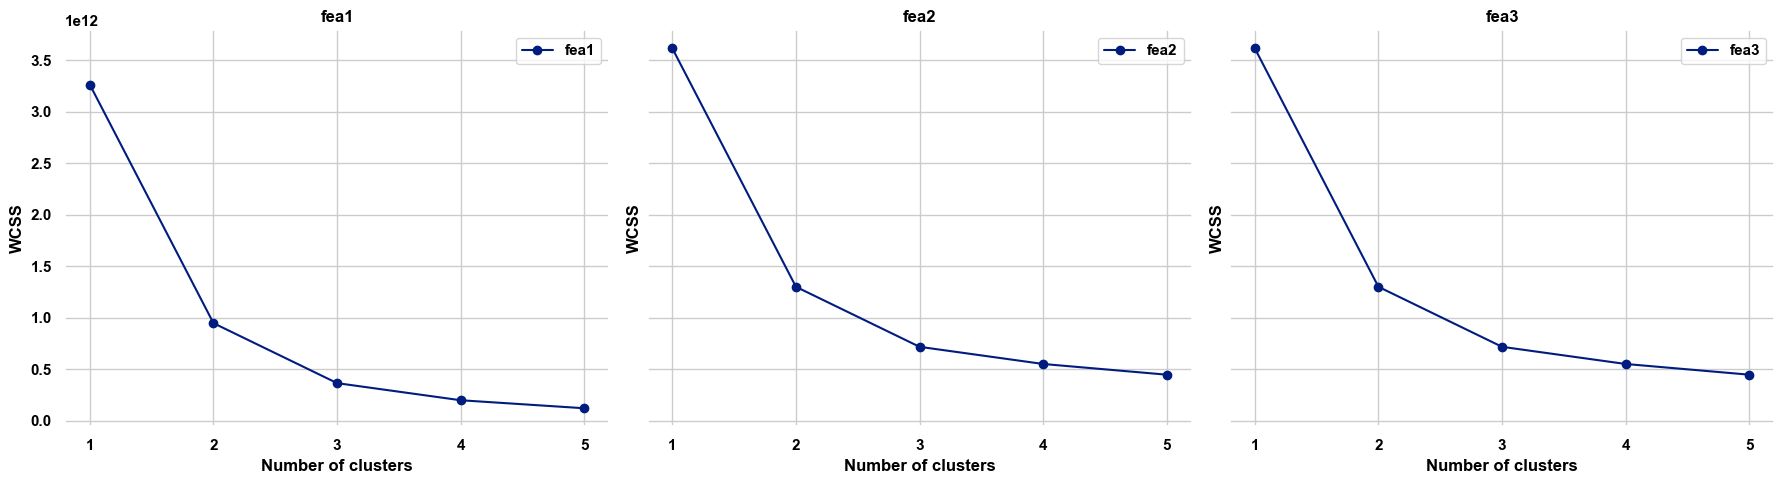

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
clusters = range(1, 6)

for ax, (name, inertia) in zip(axes, wcss.items()):
    ax.plot(clusters, inertia, marker='o', linestyle='-', label=name)
    ax.set_title(name)
    ax.set_xticks(clusters)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('WCSS')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

<span style="color:DodgerBlue;">From the above plot we can see that the Knee is located near the value 2

#### <span style="color:Khaki;">Finding knee locator in the Elbow curve using KneeLocator class:

In [41]:
optimal_k_wcss = {}

for name, inertia in wcss.items():
    kl = KneeLocator(range(1, 6), inertia, curve='convex', direction='decreasing')
    optimal_k_wcss[name] = kl.elbow

print(optimal_k_wcss)

{'fea1': np.int64(2), 'fea2': np.int64(2), 'fea3': np.int64(2)}


<span style="color:DodgerBlue;">Knee Locator also confirms that the Knee is located near the value 2

### <span style="color:Khaki;">Finding K value using silhouette score method:

In [42]:
silhouette_coefficients = {}
for name, features in feature_sets.items():
    silhouette_coefficients[name] = []
    for k in range(2,6):
        kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42)
        kmeans.fit(df1[features])
        score = silhouette_score(df1[features],kmeans.labels_)
        silhouette_coefficients[name].append(score)

print(silhouette_coefficients)

{'fea1': [np.float64(0.6792746724126905), np.float64(0.6181538338887242), np.float64(0.596403513075476), np.float64(0.6051302760912008)], 'fea2': [np.float64(0.5974657217337447), np.float64(0.4702658814518599), np.float64(0.3949255755466923), np.float64(0.4086051507167083)], 'fea3': [np.float64(0.5974657075167095), np.float64(0.4702658533113155), np.float64(0.3949255362834871), np.float64(0.4086051010071519)]}


<span style="color:DodgerBlue;">THe highest silouette scode is 36.82.

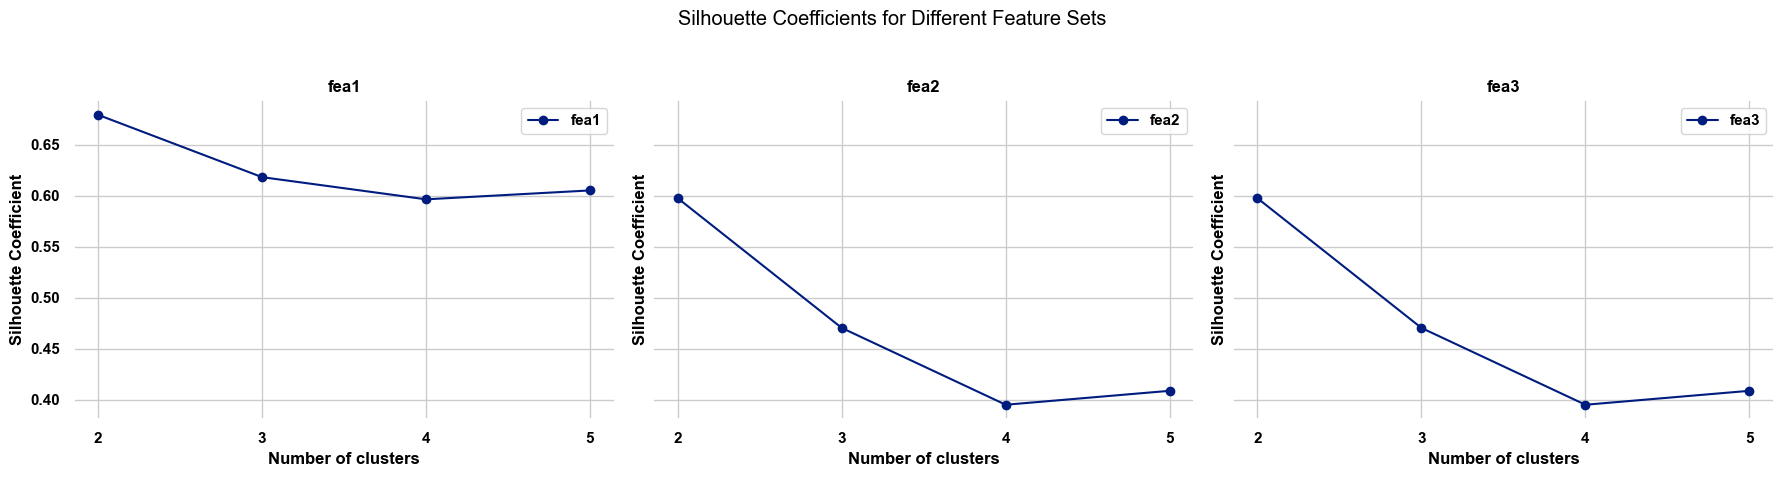

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, scores) in zip(axes, silhouette_coefficients.items()):
    ax.plot(range(2, 6), scores, marker='o', linestyle='-', label=name)
    ax.set_title(name)
    ax.set_xticks(range(2, 6))
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette Coefficient')
    ax.legend()
    ax.grid(True)

plt.suptitle('Silhouette Coefficients for Different Feature Sets')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<span style="color:DodgerBlue;">We can see the highest Silhouette score is near the vale2  The Silhouette score also confirms that the Knee is located near the value 2. 

In [44]:
optimal_k_silhouette = {}

for name, scores in silhouette_coefficients.items():
    optimal_k = range(2, 6)[scores.index(max(scores))]
    optimal_k_silhouette[name] = optimal_k
    
for name, optimal_k in optimal_k_silhouette.items():
    print(f"Optimal number of clusters for {name} (Silhouette): {optimal_k}")

Optimal number of clusters for fea1 (Silhouette): 2
Optimal number of clusters for fea2 (Silhouette): 2
Optimal number of clusters for fea3 (Silhouette): 2


<span style="color:DodgerBlue;"> Both WCSS and Silhouette confirms that the possible and meaningful cluster is 2 when we use all relevant features.

#### <span style="color:Khaki;"> Differnciating cluters using PCA and visualizing via Scatter plot:

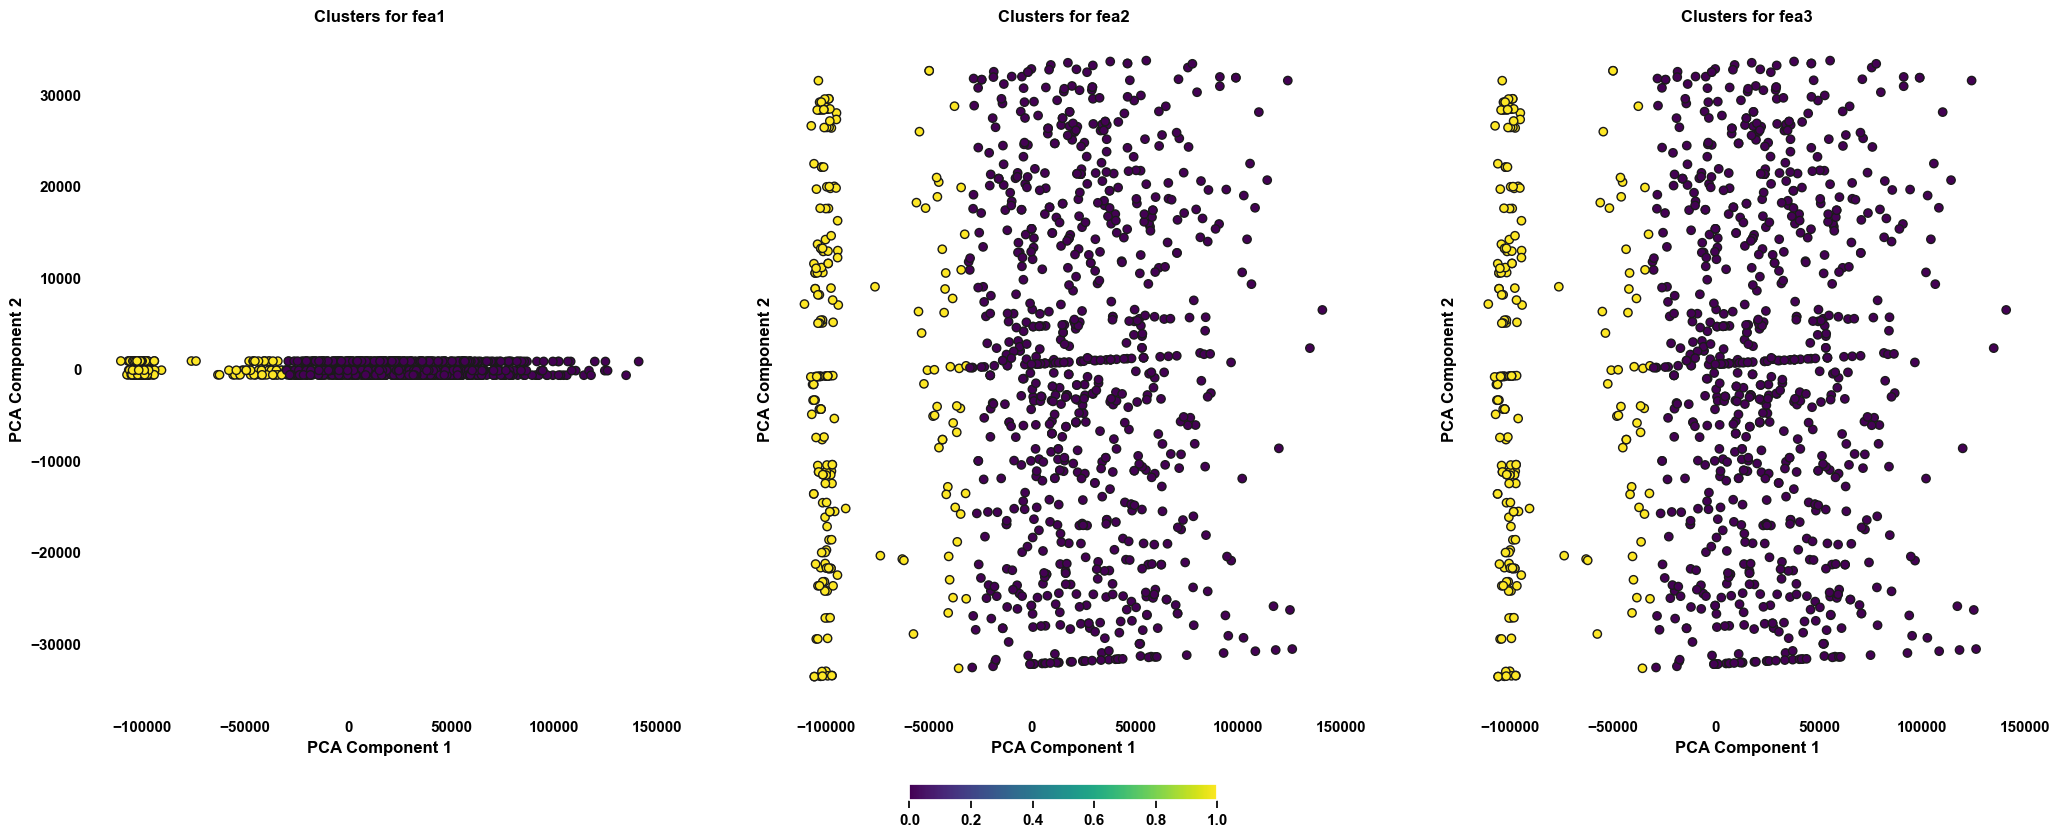

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(25, 10), sharex=True, sharey=True)

for ax, (name, features) in zip(axes, feature_sets.items()):
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(df1[features])
    
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df1[features])
    
    scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
    ax.set_title(f'Clusters for {name}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    
plt.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.show()


This suggests that the simpler model with fewer features (fea1) is more effective at creating distinct, well-separated clusters. The additional features in fea2 and fea3 may be introducing noise or redundant information that doesn't improve the clustering performance.

## <span style="color:Aqua;">Training the model after scaling the data:</span>

Removed additional features that we created using original features as a part of Feature engineering.

### <span style="color:Tomato;"> From the above we can see the possible and meaningful cluster is two.

# <span style="color:Tomato;">Training the model after scaling the dataset:</span>


#### <span style="color:Khaki;"> Scaling the data:

In [46]:
continuous_features = ['months_as_customer', 'policy_deductable', 'auto_year', 'age_boxcox', 
                       'policy_annual_premium_boxcox', 'total_claim_amount_boxcox', 
                       'insurance_age', 'vehicle_age']

categorical_features = [col for col in fea1 if col not in continuous_features]


In [47]:
df1[fea1].shape

(1000, 65)

In [48]:
scales = {'std_scale' : StandardScaler(),
'mm_scale' : MinMaxScaler(feature_range=(0,1)),
'rob_scale' : RobustScaler()
}
scaled_dfs = {}
for scaler_name, scaler in scales.items():
    scaled_continuous = scaler.fit_transform(df1[continuous_features])
    scaled_df = np.hstack((scaled_continuous, df1[categorical_features].values))

    scaled_dfs[scaler_name] = scaled_df
    print(scaler_name, '---', scaled_df.shape)

std_scale --- (1000, 65)
mm_scale --- (1000, 65)
rob_scale --- (1000, 65)


#### <span style="color:Khaki;"> Training the model:

In [49]:
silhouette_avg = {}
calinski_harabasz = {}
davies_bouldin = {}
labels = {}

for scaler_name, scaled_df in scaled_dfs.items():
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(scaled_df)
    labels[scaler_name] = kmeans.labels_

    silhouette_avg[scaler_name] = silhouette_score(scaled_df, kmeans.labels_)
    calinski_harabasz[scaler_name] = calinski_harabasz_score(scaled_df, kmeans.labels_)
    davies_bouldin[scaler_name] = davies_bouldin_score(scaled_df, kmeans.labels_)

In [50]:
print(f"silhouette_avg -- {silhouette_avg}")
print(f"calinski_harabasz -- {calinski_harabasz}")
print(f"davies_bouldin -- {davies_bouldin}")
[f"{scaler_name} -- {np.unique(labels['mm_scale'])}" for scaler_name in labels.keys()]

silhouette_avg -- {'std_scale': np.float64(0.14634134941797308), 'mm_scale': np.float64(0.23401507305350136), 'rob_scale': np.float64(0.18687074356103933)}
calinski_harabasz -- {'std_scale': np.float64(194.5846421936575), 'mm_scale': np.float64(399.41078972536474), 'rob_scale': np.float64(279.05327037533715)}
davies_bouldin -- {'std_scale': np.float64(2.22013269080217), 'mm_scale': np.float64(1.5459334232496538), 'rob_scale': np.float64(1.8449032034466526)}


['std_scale -- [0 1]', 'mm_scale -- [0 1]', 'rob_scale -- [0 1]']

### <span style="color:Tomato;"> The model's clustering quality is good when we use direct dataset rather than scaled data. So we are going to model without scaling the data. Silouette score is good when we use Original features so we will use this for modeling.

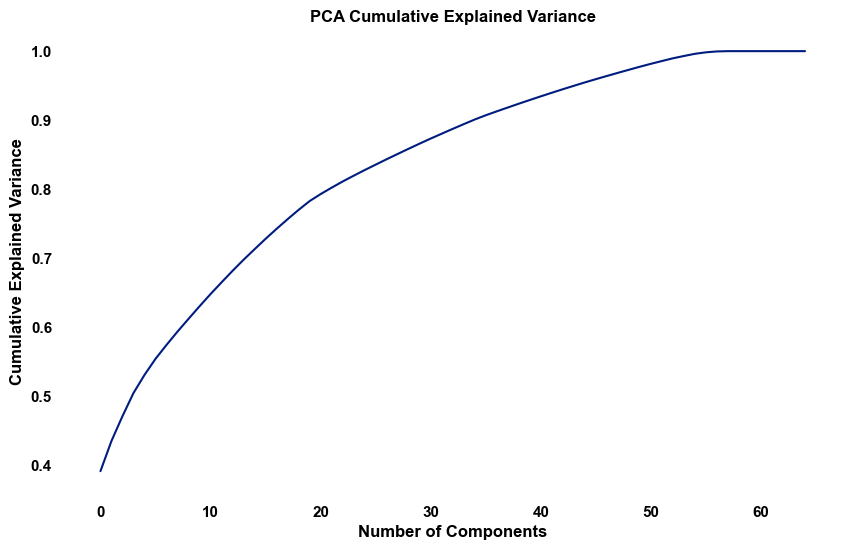

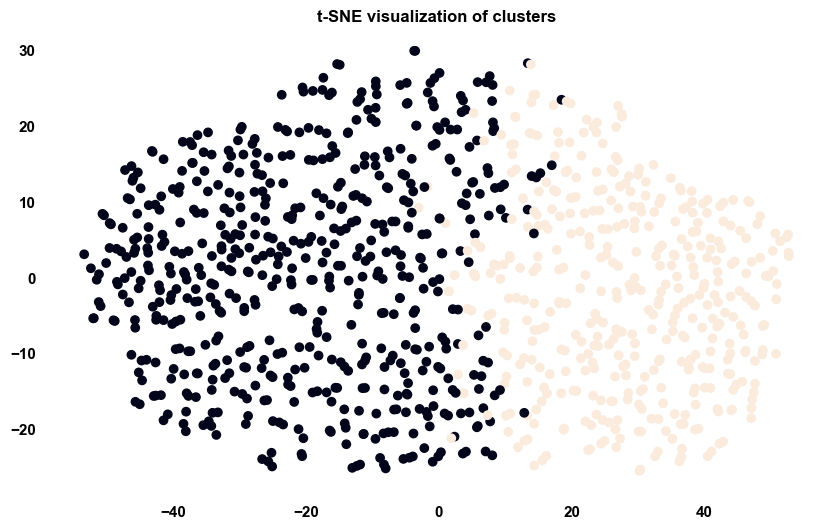

Cluster 0 mean values:
age_boxcox                          4.1725
policy_annual_premium_boxcox     1264.2658
total_claim_amount_boxcox      106819.0922
vehicle_claim_boxcox            86043.6692
dtype: float64

Cluster 1 mean values:
age_boxcox                          4.2010
policy_annual_premium_boxcox     1253.4981
total_claim_amount_boxcox      115320.7318
vehicle_claim_boxcox            92671.0227
dtype: float64


In [51]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Ensure continuous_features only contains numerical columns
continuous_features = df1.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df1.select_dtypes(include=['category', 'object']).columns.tolist()

# PCA for feature importance
pca = PCA()
pca_result = pca.fit_transform(scaled_dfs['mm_scale'])

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.show()

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_dfs['mm_scale'])

plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels['mm_scale'])
plt.title('t-SNE visualization of clusters')
plt.show()

# Analyze cluster characteristics
cluster_0 = df1[labels['mm_scale'] == 0]
cluster_1 = df1[labels['mm_scale'] == 1]

print("Cluster 0 mean values:")
print(cluster_0[continuous_features].mean())
print("\nCluster 1 mean values:")
print(cluster_1[continuous_features].mean())

# For categorical features, look at the most common values in each cluster
for feature in categorical_features:
    print(f"\nMost common {feature} in Cluster 0:", cluster_0[feature].value_counts().index[0])
    print(f"Most common {feature} in Cluster 1:", cluster_1[feature].value_counts().index[0])

# Additional analysis: distribution of categorical variables
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    cluster_0[feature].value_counts(normalize=True).plot(kind='bar', alpha=0.5, label='Cluster 0')
    cluster_1[feature].value_counts(normalize=True).plot(kind='bar', alpha=0.5, label='Cluster 1')
    plt.title(f'Distribution of {feature} in Clusters')
    plt.legend()
    plt.show()

## <span style="color:Aqua;">Creating cluster using the Original Features:</span>


In [52]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df1[fea1])
df1['Cluster'] = kmeans.predict(df1[fea1])
silhouette = silhouette_score(df1[fea1], kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df1[fea1], kmeans.labels_)
davies_bouldin = davies_bouldin_score(df1[fea1], kmeans.labels_)

In [53]:
print(f"Clusters unique values -- {np.unique(kmeans.labels_)} \nSilhouette Score -- {silhouette} \
      \ncalinski_harabasz Score -- {calinski_harabasz} \ndavies_bouldin -- {davies_bouldin}")

Clusters unique values -- [0 1] 
Silhouette Score -- 0.6792746724126905       
calinski_harabasz Score -- 2443.51517382837 
davies_bouldin -- 0.4022934136786408


In [54]:
df1

,months_as_customer,policy_bind_date,policy_deductable,insured_sex,insured_education_level,incident_date,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,auto_year,fraud_reported,age_boxcox,policy_annual_premium_boxcox,total_claim_amount_boxcox,injury_claim_cube,property_claim_cube,vehicle_claim_boxcox,insurance_age,vehicle_age,policy_state__IL,policy_state__IN,policy_state__OH,insured_hobbies__base-jumping,insured_hobbies__basketball,insured_hobbies__board-games,insured_hobbies__bungie-jumping,insured_hobbies__camping,insured_hobbies__chess,insured_hobbies__cross-fit,insured_hobbies__dancing,insured_hobbies__exercise,insured_hobbies__golf,insured_hobbies__hiking,insured_hobbies__kayaking,insured_hobbies__movies,insured_hobbies__paintball,insured_hobbies__polo,insured_hobbies__reading,insured_hobbies__skydiving,insured_hobbies__sleeping,insured_hobbies__video-games,insured_hobbies__yachting,insured_occ__adm-clerical,insured_occ__armed-forces,insured_occ__craft-repair,insured_occ__exec-managerial,insured_occ__farming-fishing,insured_occ__handlers-cleaners,insured_occ__machine-op-inspct,insured_occ__other-service,insured_occ__priv-house-serv,insured_occ__prof-specialty,insured_occ__protective-serv,insured_occ__sales,insured_occ__tech-support,insured_occ__transport-moving,insured_rela__husband,insured_rela__not-in-family,insured_rela__other-relative,insured_rela__own-child,insured_rela__unmarried,insured_rela__wife,incident_type__Multi-vehicle Collision,incident_type__Parked Car,incident_type__Single Vehicle Collision,incident_type__Vehicle Theft,collision_type__Front Collision,collision_type__Others,collision_type__Rear Collision,collision_type__Side Collision,authorities_contacted__Ambulance,authorities_contacted__Fire,authorities_contacted__Other,authorities_contacted__Police,incident_state__NC,incident_state__NY,incident_state__OH,incident_state__PA,incident_state__SC,incident_state__VA,incident_state__WV,incident_city__Arlington,incident_city__Columbus,incident_city__Hillsdale,incident_city__Northbend,incident_city__Northbrook,incident_city__Riverwood,incident_city__Springfield,auto_make__Accura,auto_make__Audi,auto_make__BMW,auto_make__Chevrolet,auto_make__Dodge,auto_make__Ford,auto_make__Honda,auto_make__Jeep,auto_make__Mercedes,auto_make__Nissan,auto_make__Saab,auto_make__Suburu,auto_make__Toyota,auto_make__Volkswagen,Cluster
0,328,2014-10-17,1000,1,4,2015-01-25,0,5,1,1,1,2,0,2004,1,4.4951,1410.9388,151203.6618,15160,-9792,123449.0081,1,11,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,228,2006-06-27,2000,1,4,2015-01-21,1,8,1,1,0,0,0,2007,1,4.3172,1200.3887,8818.7059,5824,5824,6576.0925,9,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,134,2000-09-06,2000,0,6,2015-02-22,1,7,3,0,2,3,0,2007,0,3.8331,1417.1946,69377.5346,-16576,-26648,51009.4586,15,8,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,256,1990-05-25,2000,0,6,2015-01-10,0,5,1,1,1,2,0,2014,1,4.2853,1419.8054,132680.6872,25664,25664,119948.3114,25,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,228,2014-06-06,1000,1,0,2015-02-17,1,20,1,0,0,1,0,2009,0,4.3790,1588.6789,11513.7542,-28864,29160,8719.8829,1,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [55]:
df1.to_feather('clustered.feather')

## <span style="color:Aqua;">Clusters Summary:</span>

In [34]:
cols = ['incident_hour_of_the_day', 'number_of_vehicles_involved','bodily_injuries', 'witnesses', 'auto_year']

df1[cols] = df1[cols].apply(lambda x: pd.to_numeric(x, errors='coerce', downcast='integer'))

In [36]:
df1.groupby('Cluster').mean()

,months_as_customer,policy_bind_date,policy_deductable,insured_sex,insured_education_level,incident_date,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,auto_year,fraud_reported,age_boxcox,policy_annual_premium_boxcox,total_claim_amount_boxcox,injury_claim_cube,property_claim_cube,vehicle_claim_boxcox,insurance_age,vehicle_age,policy_state__IL,policy_state__IN,policy_state__OH,insured_hobbies__base-jumping,insured_hobbies__basketball,insured_hobbies__board-games,insured_hobbies__bungie-jumping,insured_hobbies__camping,insured_hobbies__chess,insured_hobbies__cross-fit,insured_hobbies__dancing,insured_hobbies__exercise,insured_hobbies__golf,insured_hobbies__hiking,insured_hobbies__kayaking,insured_hobbies__movies,insured_hobbies__paintball,insured_hobbies__polo,insured_hobbies__reading,insured_hobbies__skydiving,insured_hobbies__sleeping,insured_hobbies__video-games,insured_hobbies__yachting,insured_occ__adm-clerical,insured_occ__armed-forces,insured_occ__craft-repair,insured_occ__exec-managerial,insured_occ__farming-fishing,insured_occ__handlers-cleaners,insured_occ__machine-op-inspct,insured_occ__other-service,insured_occ__priv-house-serv,insured_occ__prof-specialty,insured_occ__protective-serv,insured_occ__sales,insured_occ__tech-support,insured_occ__transport-moving,insured_rela__husband,insured_rela__not-in-family,insured_rela__other-relative,insured_rela__own-child,insured_rela__unmarried,insured_rela__wife,incident_type__Multi-vehicle Collision,incident_type__Parked Car,incident_type__Single Vehicle Collision,incident_type__Vehicle Theft,collision_type__Front Collision,collision_type__Others,collision_type__Rear Collision,collision_type__Side Collision,authorities_contacted__Ambulance,authorities_contacted__Fire,authorities_contacted__Other,authorities_contacted__Police,incident_state__NC,incident_state__NY,incident_state__OH,incident_state__PA,incident_state__SC,incident_state__VA,incident_state__WV,incident_city__Arlington,incident_city__Columbus,incident_city__Hillsdale,incident_city__Northbend,incident_city__Northbrook,incident_city__Riverwood,incident_city__Springfield,auto_make__Accura,auto_make__Audi,auto_make__BMW,auto_make__Chevrolet,auto_make__Dodge,auto_make__Ford,auto_make__Honda,auto_make__Jeep,auto_make__Mercedes,auto_make__Nissan,auto_make__Saab,auto_make__Suburu,auto_make__Toyota,auto_make__Volkswagen
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,205.8714,2002-03-22 15:27:35.064935040,1141.5584,0.4675,3.0312,2015-01-29 20:58:35.844155904,0.9987,12.4662,2.0000,0.6636,1.0013,1.4779,0.3481,2005.0026,0.2870,4.1899,1263.7603,136628.8486,-1266.9403,-708.1247,109849.6889,13.2831,9.9974,0.3377,0.3091,0.3532,0.0455,0.0390,0.0494,0.0545,0.0584,0.0481,0.0416,0.0403,0.0584,0.0506,0.0597,0.0532,0.0494,0.0519,0.0442,0.0610,0.0494,0.0455,0.0481,0.0519,0.0571,0.0714,0.0766,0.0792,0.0519,0.0610,0.0961,0.0662,0.0727,0.0831,0.0649,0.0662,0.0779,0.0753,0.1727,0.1766,0.1740,0.1805,0.1416,0.1545,0.5013,0.0000,0.4987,0.0000,0.3091,0.0000,0.3571,0.3338,0.2351,0.2701,0.2506,0.2442,0.1026,0.2831,0.0234,0.0299,0.2558,0.1039,0.2013,0.1416,0.1623,0.1429,0.1481,0.1182,0.1299,0.1571,0.0701,0.0688,0.0727,0.0740,0.0818,0.0740,0.0545,0.0636,0.0636,0.0818,0.0831,0.0857,0.0623,0.0636
1,197.5348,2001-09-19 01:58:57.391304320,1117.3913,0.4478,2.7478,2015-01-31 21:04:41.739130368,1.8043,8.8913,1.3000,0.6261,0.9609,1.5174,0.4130,2005.4391,0.1130,4.1655,1246.6699,22250.2362,-1160.5217,10.7826,18216.8626,13.7739,9.5609,0.3391,0.3130,0.3478,0.0609,0.0174,0.0435,0.0609,0.0435,0.0391,0.0130,0.0522,0.0522,0.0696,0.0261,0.0565,0.0739,0.0739,0.0565,0.0739,0.0478,0.0261,0.0565,0.0565,0.0913,0.0609,0.0652,0.0652,0.0565,0.0304,0.0826,0.0870,0.0652,0.0913,0.0565,0.1087,0.0783,0.0609,0.1609,0.1652,0.1870,0.1913,0.1391,0.1565,0.1435,0.3652,0.0826,0.4087,0.0696,0.7739,0.0739,0.0826,0.1130,0.0652,0.2478,0

Credit_Mix_map = { 'Poor': 0,'Bad':0, 'Standard':1, 'Good': 2  }
Payment_of_Min_Amount_map = { 'No':0, 'Nm':1, 'Yes':2 }
Payment_Behaviour_map = { 'Low_Spent_Small_Value_Payments': 0 , 'Low_Spent_Medium_Value_Payments':1, 'Low_Spent_Large_Value_Payments':2,
                         'High_Spent_Small_Value_Payments':3, 'High_Spent_Medium_Value_Payments':4, 'High_Spent_Large_Value_Payments':5
                        }
age_group_map = {'<18': 0, '18-25': 1, '26-35': 2, '36-50': 3, '50+': 4,}

## <span style="color:Khaki;">Clusters Overview:</span>

<table border="3" style="width:100%; border-collapse: collapse;">
    <tr>
        <th style="background-color:Maroon; color:white; font-size:130%; text-align:center;"><b>Cluster 0 (Lower Risk / Better Financial Health)</b></th>
        <th style="background-color:Maroon; color:white; font-size:130%; text-align:center;"><b>Cluster 1 (Higher Risk / Poorer Financial Health)</b></th>
    </tr>
    <tr>
        <td style="width:50%;">
        <span style="color:Khaki;font-size:110%;"><b>Credit Behavior:</b> </span>
            <ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
                <li>Lower number of bank accounts (5) and credit cards (5)</li>
                <li>Fewer loans (3) and credit inquiries (4)</li>
                <li>Better credit mix (1 = Standard) and credit score (1 = Good)</li>
                <li>Lower delay from due date (14 days) and fewer delayed payments (12)</li>
            </ol>
            <span style="color:Khaki;font-size:110%;"><b>Income and Spending:</b></span>
            <ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
                <li>Higher disposable income (3240.178)</li>
                <li>Higher annual income (13.9232 boxcox transformed)</li>
                <li>Higher monthly inhand salary (11.6471 boxcox transformed)</li>
                <li>Lower outstanding debt (30.3891 squared)</li>
            </ol>
            <span style="color:Khaki;font-size:110%;"><b>Financial Management:</b></span>
            <ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
                <li>Higher savings rate (75.7477)</li>
                <li>Lower debt-to-income ratio (8.5042 log transformed)</li>
                <li>Better payment behavior (2 = Low Spent Large Value Payments)</li>
                <li>More likely to pay minimum amount (1 = Sometimes)</li>
            </ol>
        </td>
        <td style="width:50%;">
        <span style="color:Khaki;font-size:110%;"><b>Credit Behavior:</b></span>
            <ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
                <li>Higher number of bank accounts (8) and credit cards (7)</li>
                <li>More loans (6) and credit inquiries (10)</li>
                <li>Poorer credit mix (0 = Poor/Bad) and credit score (0 = Poor)</li>
                <li>Higher delay from due date (44 days) and more delayed payments (19)</li>
            </ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
            <span style="color:Khaki;font-size:110%;"><b>Income and Spending:</b></span>
            <ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
                <li>Lower disposable income (2148.579)</li>
                <li>Lower annual income (13.3624 boxcox transformed)</li>
                <li>Lower monthly inhand salary (10.9237 boxcox transformed)</li>
                <li>Higher outstanding debt (50.7106 squared)</li>
            </ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
            <span style="color:Khaki;font-size:110%;"><b>Financial Management:</b></span>
            <ol style="border-bottom: 1px solid #ddd; padding-bottom: 10px;">
                <li>Lower savings rate (62.8947)</li>
                <li>Higher debt-to-income ratio (7.5518 log transformed)</li>
                <li>Poorer payment behavior (2 = Low Spent Large Value Payments, but with higher risk indicators)</li>
                <li>More likely to not pay minimum amount (2 = Yes, but with higher risk context)</li>
            </ol>
        </td>
    </tr>
</table>

## <span style="color:Khaki;">Key Insights:</span>
<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Risk Segmentation: </span>The clustering has effectively separated customers into lower-risk (Cluster 0) and higher-risk (Cluster 1) groups.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Credit Utilization: </span>Cluster 1 customers have more credit products but poorer credit scores, suggesting overextension of credit.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Payment Behavior: </span> Cluster 0 customers are more punctual with payments and have fewer delays.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Income vs. Debt: </span> Despite lower incomes, Cluster 1 customers have higher outstanding debt, indicating potential financial stress.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Financial Management: </span> Cluster 0 customers show better financial management with higher savings rates and lower debt-to-income ratios.

<span style="color: Chartreuse;font-size:120%;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Credit Inquiries: </span> The higher number of credit inquiries in Cluster 1 might indicate these customers are seeking more credit, possibly due to financial difficulties.

<span style="color: white;font-size:105%;"> These insights can be used to tailor financial products, adjust risk assessments, and develop targeted financial education or assistance programs for each cluster. The clear separation between clusters suggests that this segmentation could be valuable for strategic decision-making in customer relationship management and risk mitigation. </span>

# <span style="color:Aqua;">Training DB Scan model:</span>


In [146]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Assuming df1[fea1] contains your data
X = df1[fea1].values

# Standard DBSCAN parameters
eps = 0.5  # You might need to adjust this value based on your data
min_samples = 5  # Minimum number of samples in a neighborhood for a point to be a core point


In [150]:
# Initialize DBSCAN
dbscan = DBSCAN()

# Fit DBSCAN and predict clusters
labels = dbscan.fit_predict(X)

# Calculate silhouette score, if applicable
# Silhouette score is not defined when all points are noise or there’s only one cluster
if len(set(labels)) > 1 and set(labels) != {-1}:
    score = silhouette_score(X, labels)
else:
    score = "Not applicable (no valid clusters or all points are noise)"

# Print clustering results
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Subtract 1 if there are noise points
n_noise = list(labels).count(-1)  # Number of noise points

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Silhouette score: {score}")


Number of clusters: 0
Number of noise points: 1000
Silhouette score: Not applicable (no valid clusters or all points are noise)


In [152]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Sample data and feature set
X = df1[fea1].values

# Define DBSCAN parameters
eps = 0.5
min_samples = 5

# Apply DBSCAN
dbscan = DBSCAN()
labels = dbscan.fit_predict(X)

# Calculate silhouette score
if len(set(labels)) > 1 and set(labels) != {-1}:
    score = silhouette_score(X, labels)
else:
    score = "Not applicable (no valid clusters or all points are noise)"

# Print results
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Silhouette score: {score}")


Number of clusters: 0
Number of noise points: 1000
Silhouette score: Not applicable (no valid clusters or all points are noise)
